# Curso: CC521 A Programación Evolutiva 2022-1
Alumno: Jordi Joel Bardales Rojas

## Práctica dirigida: Representación y Selección 


In [52]:
from __future__ import annotations
import random
import matplotlib.pyplot as plt
from typing import Callable
import copy
from representation import Individual, IndividualArguments
from mutation import Mutation, OneFlipMutation, UniformMutation, SwapMutation, ReversingMutation
from crossover import Crossover, OnePointCrossover, NPointCrossover, ShuffleCrossover, UniformCrossover
from selection import Selection, ProportionalSelection, LinearRankingSelection, TournamentSelection, UniformSelection, RouletteSelection

## Algoritmo Genético binario (Cuaderno de notas del Colab)

Para las dos primeras funciones de De Jong:


In [92]:
F1 = lambda x: x[0]**2 + x[1]**2 + x[2]**2
# dominio
domain_1, n_var_1 = [-1.0, 1], 3
# tamaño del gen
GEN_SIZE_1 = 10
# precisión
eps_1 = (domain_1[1] - domain_1[0]) / (2**GEN_SIZE_1 - 1)
# argumentos para el experimento 1
args_1 = IndividualArguments(domain_1, eps_1, n_var_1, GEN_SIZE_1)


In [91]:
F2 = lambda x: 100 * (x[0]**2 - x[1])**2 + (1 - x[0])**2
# dominio
domain_2, n_var_2 = [-2, 2.0], 2
# tamaño del gen
GEN_SIZE_2 = 10
# presición
eps_2 = (domain_2[1] - domain_2[0]) / (2**GEN_SIZE_2 - 1)
# argumentos para el experimento 2
args_2 = IndividualArguments(domain_2, eps_2, n_var_2, GEN_SIZE_2)

#### Esquema general de un AE genérico 

In [289]:
def genenetic_algorithm(max_generation: int,
                        t: int,
                        fitness: Callable[[list[float]], float],
                        population: list[Individual],
                        selection: Selection,
                        crossover: Crossover,
                        mutation: Mutation,
                        best=False):
    collect_best: list[Individual] = []
    # promedio de promedio
    # collect_mean_online: list[float] = []
    # promedio de mejores
    collect_mean_offline: list[float] = []
    generation_number = 0
    while generation_number < max_generation:
        generation_number += 1
        # evaluacion de la aptitud de la población inicial (n individuos)
        population_fitness = [fitness(ind.phenotype) for ind in population]
        # seleccion de los padres (para la reproducción)
        parents = selection.get_individuals(population, population_fitness)
        # operadores de variación
        offspring: list[Individual] = []
        # crossover
        for p1, p2 in zip(parents[0::2], parents[1::2]):
            if (childs := crossover.make(p1, p2)) != None:
                offspring += childs
        # mutation
        for ind in parents:
            if (mutant := mutation.make(ind)) != None:
                offspring.append(mutant)
        # evaluacion de la aptitud de los λ descendientes
        offspring_fitness = [fitness(ind.phenotype) for ind in offspring]

        # λ individuos aptos + n padres
        population += offspring
        population_fitness += offspring_fitness
        # seleccionamos un individuo para la grafica
        collect_best.append(population[random.randint(0, len(population) - 1)])
        # selección del ambiente n
        population = selection.get_individuals(population, population_fitness)
        # promedio online
        if generation_number > t:
            # collect_mean_online.append(sum([fitness(ind.phenotype) for ind in population]))
            collect_mean_offline.append(min([fitness(ind.phenotype) for ind in population]))

        # impresión de la generación
        # if generation_number % int(max_generation / 10) == 0:
        #     print(f"Generación: {generation_number}, número de descendientes: {len(offspring)}")
    if best:
        plt.plot([fitness(x.phenotype) for x in collect_best], "r-")
        plt.title(f"{selection.__class__.__name__}, {crossover.__class__.__name__} & {mutation.__class__.__name__}\nGeneration number {generation_number}")
        plt.ylabel("Fitness")
        plt.xlabel("Generation")
        plt.show()
        return collect_best
    else:
        # sum(collect_mean_online) / (len(collect_mean_online) * (MAX_GENERATION - t))
        return sum(collect_mean_offline) / (MAX_GENERATION - t)


Usando las métricas "en linea" y "fuera de linea" realizar lo siguiente:

### 1. Determinar el tamaño de la población para ambas funciones, Seleccionar los hiperparámetros iniciales de acuerdo a su criterio

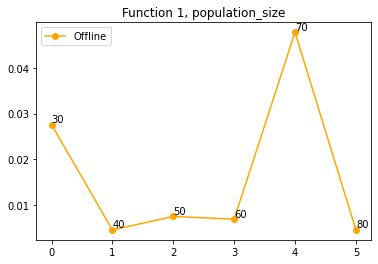

In [254]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
t = MAX_GENERATION - 5
population_size = [30, 40, 50, 60, 70, 80]
selection_size = 25
crossover_rate = 0.9
mutation_rate = 0.1

# online = []
offline = []
for i in range(len(population_size)):
    initial_population = [Individual.newRandom(args_1) for _ in range(population_size[i])]
    off = genenetic_algorithm(max_generation=MAX_GENERATION,
                              t=t,
                              fitness=F1,
                              population=initial_population,
                              selection=ProportionalSelection(num_individuals=selection_size),
                              crossover=OnePointCrossover(probability=crossover_rate),
                              mutation=OneFlipMutation(probability=mutation_rate))
    # online.append(on)
    offline.append(off)

fig, axes = plt.subplots()
# plt.plot(range(len(population_size)), online, 'o-', label="Online")
axes.set_title("Function 1, population_size")
axes.plot(range(len(population_size)), offline, 'o-', label="Offline",c="r")
plt.legend()
for i, val in enumerate(offline):
    axes.annotate(str(population_size[i]), (i, val + 0.0005))
plt.show()

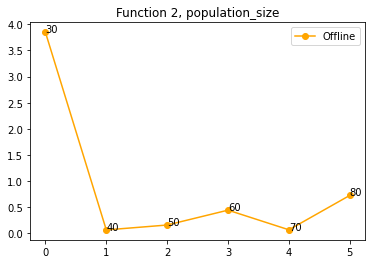

In [224]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 40
t = MAX_GENERATION - 10
population_size = [30, 40, 50, 60, 70, 80]
selection_size = 25
crossover_rate = 0.9
mutation_rate = 0.1

# online = []
offline = []
for i in range(len(population_size)):
    initial_population = [Individual.newRandom(args_2) for _ in range(population_size[i])]
    off = genenetic_algorithm(max_generation=MAX_GENERATION,
                              t=t,
                              fitness=F2,
                              population=initial_population,
                              selection=ProportionalSelection(num_individuals=selection_size),
                              crossover=OnePointCrossover(probability=crossover_rate),
                              mutation=OneFlipMutation(probability=mutation_rate))
    # online.append(on)
    offline.append(off)

fig, axes = plt.subplots()
# plt.plot(range(len(population_size)), online, 'o-', label="Online")
axes.set_title("Function 2, population_size")
axes.plot(range(len(population_size)), offline, 'o-', label="Offline",c="r")
plt.legend()
for i, val in enumerate(offline):
    axes.annotate(str(population_size[i]), (i, val + 0.0005))
plt.show()


En ambos casos el tamaño de la población es 40

### 2. Considerando la población anterior, determinar el porcentaje de cruzamiento

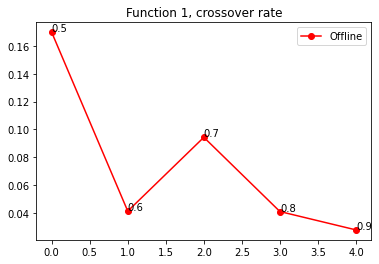

In [232]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
t = MAX_GENERATION - 5
population_size = 40
selection_size = 25
crossover_rate = [0.5, 0.6, 0.7, 0.8, 0.9]
mutation_rate = 0.1
population = [Individual.newRandom(args_1) for _ in range(population_size)]

offline = []
for i in range(len(crossover_rate)):
    initial_population = copy.copy(population)
    off = genenetic_algorithm(max_generation=MAX_GENERATION,
                              t=t,
                              fitness=F1,
                              population=initial_population,
                              selection=ProportionalSelection(num_individuals=selection_size),
                              crossover=OnePointCrossover(probability=crossover_rate[i]),
                              mutation=OneFlipMutation(probability=mutation_rate))
    offline.append(off)

fig, axes = plt.subplots()
axes.set_title("Function 1, crossover_rate")
axes.plot(range(len(crossover_rate)), offline, 'o-', label="Offline", c="r")
plt.legend()
for i, val in enumerate(offline):
    axes.annotate(str(crossover_rate[i]), (i, val + 0.0005))
plt.show()


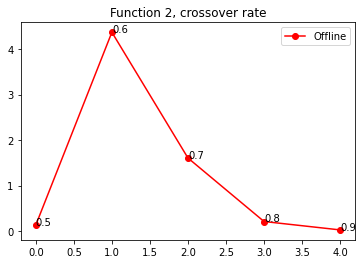

In [236]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
t = MAX_GENERATION - 5
population_size = 40
selection_size = 25
crossover_rate = [0.5, 0.6, 0.7, 0.8, 0.9]
mutation_rate = 0.1
population = [Individual.newRandom(args_2) for _ in range(population_size)]

offline = []
for i in range(len(crossover_rate)):
    initial_population = copy.copy(population)
    off = genenetic_algorithm(max_generation=MAX_GENERATION,
                              t=t,
                              fitness=F2,
                              population=initial_population,
                              selection=ProportionalSelection(num_individuals=selection_size),
                              crossover=OnePointCrossover(probability=crossover_rate[i]),
                              mutation=OneFlipMutation(probability=mutation_rate))
    offline.append(off)

fig, axes = plt.subplots()
axes.set_title("Function 2, crossover_rate")
axes.plot(range(len(crossover_rate)), offline, 'o-', label="Offline", c="r")
plt.legend()
for i, val in enumerate(offline):
    axes.annotate(str(crossover_rate[i]), (i, val + 0.0005))
plt.show()


### 3. Considerando la población y porcentaje de cruza calculados en los ítems anteriores, determinar el porcentaje de mutación

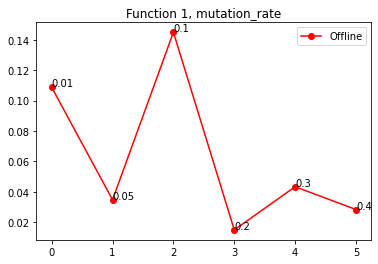

In [252]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
t = MAX_GENERATION - 5
population_size = 40
selection_size = 25
crossover_rate = 0.9
mutation_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
population = [Individual.newRandom(args_1) for _ in range(population_size)]

offline = []
for i in range(len(mutation_rate)):
    initial_population = copy.copy(population)
    off = genenetic_algorithm(max_generation=MAX_GENERATION,
                              t=t,
                              fitness=F1,
                              population=initial_population,
                              selection=ProportionalSelection(num_individuals=selection_size),
                              crossover=OnePointCrossover(probability=crossover_rate),
                              mutation=OneFlipMutation(probability=mutation_rate[i]))
    offline.append(off)

fig, axes = plt.subplots()
axes.set_title("Function 1, mutation_rate")
axes.plot(range(len(mutation_rate)), offline, 'o-', label="Offline", c="r")
plt.legend()
for i, val in enumerate(offline):
    axes.annotate(str(mutation_rate[i]), (i, val + 0.0005))
plt.show()


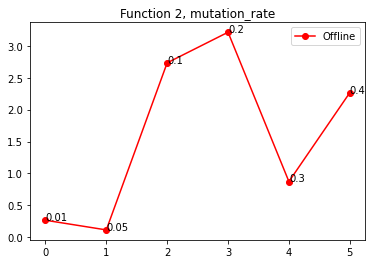

In [251]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
t = MAX_GENERATION - 5
population_size = 40
selection_size = 25
crossover_rate = 0.9
mutation_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
population = [Individual.newRandom(args_2) for _ in range(population_size)]

offline = []
for i in range(len(mutation_rate)):
    initial_population = copy.copy(population)
    off = genenetic_algorithm(max_generation=MAX_GENERATION,
                              t=t,
                              fitness=F2,
                              population=initial_population,
                              selection=ProportionalSelection(num_individuals=selection_size),
                              crossover=OnePointCrossover(probability=crossover_rate),
                              mutation=OneFlipMutation(probability=mutation_rate[i]))
    offline.append(off)

fig, axes = plt.subplots()
axes.set_title("Function 2, mutation_rate")
axes.plot(range(len(mutation_rate)), offline, 'o-', label="Offline", c="r")
plt.legend()
for i, val in enumerate(offline):
    axes.annotate(str(mutation_rate[i]), (i, val + 0.0005))
plt.show()


Utilizando todos los parámetros

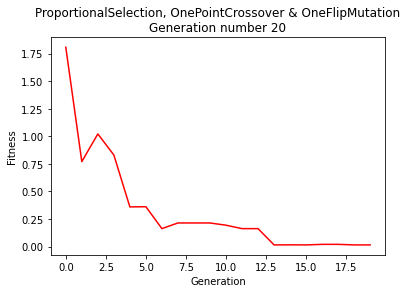

In [290]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
t = MAX_GENERATION - 5
population_size = 40
selection_size = 25
crossover_rate = 0.9
mutation_rate = 0.2
initial_population = [Individual.newRandom(args_1) for _ in range(population_size)]
best = genenetic_algorithm(max_generation=MAX_GENERATION,
                    t=t,
                    fitness=F1,
                    population=initial_population,
                    selection=ProportionalSelection(num_individuals=selection_size),
                    crossover=OnePointCrossover(probability=crossover_rate),
                    mutation=OneFlipMutation(probability=mutation_rate),
                    best=True);


In [291]:
solution1 = min(best, key=lambda x: F1(x.phenotype))
print(f"Optimal value with Tournament Selection\n x* = {solution1.phenotype}, f(x*) = {F1(solution1.phenotype)}")


Optimal value with Tournament Selection
 x* = [0.06353861192570864, -0.010752688172043001, -0.1026392961876833], f(x*) = 0.014687600630273977


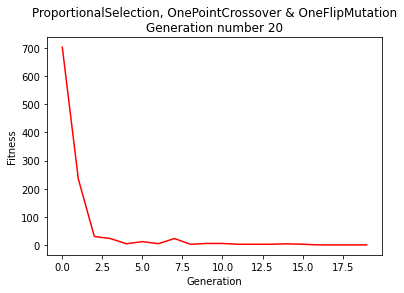

In [296]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
t = MAX_GENERATION - 5
population_size = 40
selection_size = 25
crossover_rate = 0.9
mutation_rate = 0.05
initial_population = [Individual.newRandom(args_2) for _ in range(population_size)]
best = genenetic_algorithm(max_generation=MAX_GENERATION,
                    t=t,
                    fitness=F2,
                    population=initial_population,
                    selection=ProportionalSelection(num_individuals=selection_size),
                    crossover=OnePointCrossover(probability=crossover_rate),
                    mutation=OneFlipMutation(probability=mutation_rate),
                    best=True);


In [297]:
solution2 = min(best, key=lambda x: F2(x.phenotype))
print(f"Optimal value with Tournament Selection\n x* = {solution2.phenotype}, f(x*) = {F2(solution2.phenotype)}")


Optimal value with Tournament Selection
 x* = [0.5650048875855327, 0.318670576735093], f(x*) = 0.18925210180593396


#### 4. Considerando los valores anteriores, pruebe diferentes combinaciones para los métodos de selección, cruzamiento y mutación

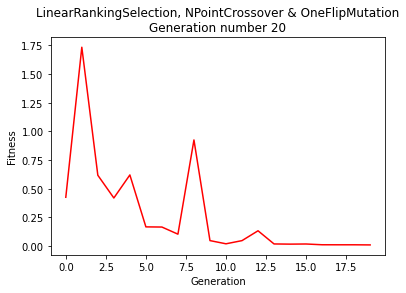

Optimal value with Tournament Selection
 x* = [-0.04985337243401755, 0.07135874877810355, -0.04203323558162264], f(x*) = 0.009344222663681545


In [299]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
t = MAX_GENERATION - 5
population_size = 40
selection_size = 25
crossover_rate = 0.9
mutation_rate = 0.2
initial_population = [Individual.newRandom(args_1) for _ in range(population_size)]
best = genenetic_algorithm(max_generation=MAX_GENERATION,
                           t=t,
                           fitness=F1,
                           population=initial_population,
                           selection=LinearRankingSelection(num_individuals=selection_size, s=1.5),
                           crossover=NPointCrossover(probability=crossover_rate, n=2),
                           mutation=OneFlipMutation(probability=mutation_rate),
                           best=True)
solution1 = min(best, key=lambda x: F1(x.phenotype))
print(f"Optimal value with Tournament Selection\n x* = {solution1.phenotype}, f(x*) = {F1(solution1.phenotype)}")


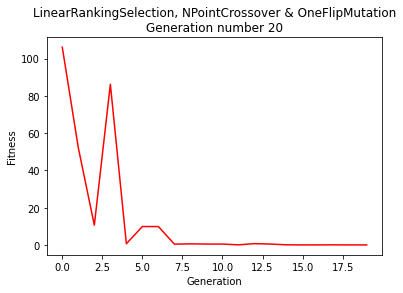

In [305]:
# GA CANONICAL HYPERPARAMETERS
MAX_GENERATION = 20
t = MAX_GENERATION - 5
population_size = 40
selection_size = 25
crossover_rate = 0.9
mutation_rate = 0.2
initial_population = [Individual.newRandom(args_2) for _ in range(population_size)]
best = genenetic_algorithm(max_generation=MAX_GENERATION,
                           t=t,
                           fitness=F2,
                           population=initial_population,
                           selection=LinearRankingSelection(num_individuals=selection_size, s=1.5),
                           crossover=NPointCrossover(probability=crossover_rate, n=2),
                           mutation=OneFlipMutation(probability=mutation_rate),
                           best=True)


In [306]:
solution2 = min(best, key=lambda x: F2(x.phenotype))
print(f"Optimal value with Tournament Selection\n x* = {solution2.phenotype}, f(x*) = {F2(solution2.phenotype)}")


Optimal value with Tournament Selection
 x* = [1.0733137829912023, 1.139784946236559], f(x*) = 0.020301715982879453
